In [53]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
import numpy as np
import missingno

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, fbeta_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from category_encoders import BinaryEncoder

import tensorflow as tf
from tensorflow.keras import optimizers, Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Input
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import joblib



In [ ]:
df = pd.read_csv("train_data.csv")
timestep_X = 5 #from 1 to 17 -> lower values give more data
timestep_y = 1 #timestep to predict
threshold_for_classification = -29.99
fill_X = -0.1
X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
seed = 11

In [ ]:
#Dropping first the empty column and then rows with NaNs
df = df.drop("c_rcs_estimate", axis=1)
df = df.dropna(how='any')

#Filtering events with len=1 or min_tca > 3 or max_tca < 3
def conditions(event):
    x = event["time_to_tca"].values
    return ((x.min()<3.0) & (x.max()>3.0))

df = df.groupby('event_id').filter(conditions)

#OHE for c_object_type (5 categories) -> 5 new features
df["mission_id"] = df["mission_id"].astype('category')
df["c_object_type"] = df["c_object_type"].astype('category')
df = pd.get_dummies(df)

#Adding feature 'event_length' for counting how many instances each event has
df["event_length"] = df.groupby('event_id')['event_id'].transform('count')

#Scaling data
_ = y_scaler.fit(df["risk"].values.reshape(-1, 1)) #for later use for scaling prediction
df = pd.DataFrame(X_scaler.fit_transform(df), columns=df.columns)

#Transforming dataframe into a 3D-array with overlapping windows
data = []
timestep = timestep_X + timestep_y
def df_to_3darray(event):
    global data
    event = event.values
    if(timestep>=event.shape[0]):
        pad_shape = timestep + 1
        pad_event = np.zeros((pad_shape,event.shape[1]))
        pad_event.fill(fill_X)
        pad_event[-event.shape[0]:,:] = event
        event = pad_event
    for i in range(event.shape[0]-timestep):
        data.append(event[i:i+timestep,:])
    return event

df.groupby("event_id").apply(df_to_3darray)
data = np.array(data)

#Dividing X and y
target_feture = list(df.columns).index("risk")
X, y = data[:,:timestep_X,:], data[:,timestep_X:,target_feture]

#Dropping event_id to remove noise
X = X[:,:,1:]

#TODO: Padding with specific values column-wise instead of fixed number.
#TODO: Separating time dependent and independent feature in 2 X arrays

print(X.shape, y.shape)

(83670, 5, 124) (83670, 1)


In [ ]:
#computing scaled threshold 
th = np.array([threshold_for_classification]).reshape(-1,1)
th = y_scaler.transform(th)
threshold_scaled = th[0,0]

#y boolean for splitting
y_boolean = (y > threshold_scaled).reshape(-1,1)

#Splitting arrays
X_train, X_test, y_train_numeric, y_test_numeric = train_test_split(X, y, 
                                                    stratify=y_boolean, 
                                                    shuffle=True,
                                                    random_state=seed,
                                                    test_size = 0.1
                                                  )

#transforming it into a classification task -> y_train, y_test boolean
y_train = (y_train_numeric > threshold_scaled).reshape(-1,1)
y_test = (y_test_numeric > threshold_scaled).reshape(-1,1)

#percentage of high risk
print("High risk: {:0.2f}".format(np.sum(y_test)/y_test.shape[0]))

High risk: 0.48


In [ ]:
#hiperparameter
epochs = 30
batch = 64
val_split = 0.3
lr = 0.0001
adam = optimizers.Adam(lr)
#class_weight = {True: 1.,
#                False: 50.}
verbose = 1


# Model activation selu
input_tensor = Input(batch_shape=(None, timestep_X, X_train.shape[2]))
rnn_1 = LSTM(32, stateful=False, dropout=0.1, return_sequences=True)(input_tensor)
rnn_2 = LSTM(16, stateful=False, dropout=0.1, return_sequences=False)(rnn_1)
output_tensor = Dense(units = 1, activation='sigmoid')(rnn_2)

model = Model(inputs=input_tensor,
              outputs= output_tensor)

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 124)]          0         
                                                                 
 lstm (LSTM)                 (None, 5, 32)             20096     
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 23249 (90.82 KB)
Trainable params: 23249 (90.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_history = model.fit(X_train, y_train, 
                          epochs=epochs, 
                          batch_size=batch,
                          validation_split=val_split,
                          verbose=verbose,
                         ).history

Epoch 1/30


824/824 [==============================] - 9s 8ms/step - loss: 0.4925 - accuracy: 0.7723 - val_loss: 0.3683 - val_accuracy: 0.8414
Epoch 2/30
824/824 [==============================] - 7s 9ms/step - loss: 0.3702 - accuracy: 0.8405 - val_loss: 0.3259 - val_accuracy: 0.8631
Epoch 3/30
824/824 [==============================] - 7s 9ms/step - loss: 0.3305 - accuracy: 0.8628 - val_loss: 0.2968 - val_accuracy: 0.8801
Epoch 4/30
824/824 [==============================] - 7s 9ms/step - loss: 0.3051 - accuracy: 0.8757 - val_loss: 0.2772 - val_accuracy: 0.8907
Epoch 5/30
824/824 [==============================] - 7s 8ms/step - loss: 0.2907 - accuracy: 0.8840 - val_loss: 0.2634 - val_accuracy: 0.8984
Epoch 6/30
824/824 [==============================] - 6s 8ms/step - loss: 0.2787 - accuracy: 0.8916 - val_loss: 0.2564 - val_accuracy: 0.9032
Epoch 7/30
824/824 [==============================] - 7s 8ms/step - loss: 0.2725 - accuracy: 0.8952 - val_loss: 0.2508 - val_accuracy: 0.9082
Epoc

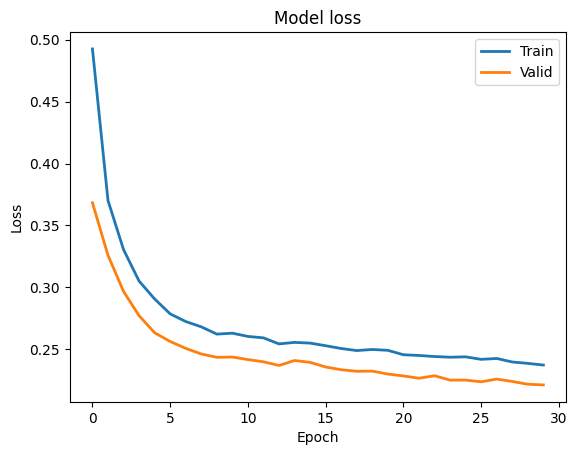

In [ ]:
plt.plot(model_history['loss'], linewidth=2, label='Train')
plt.plot(model_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

131/131 [==============================] - 0s 2ms/step


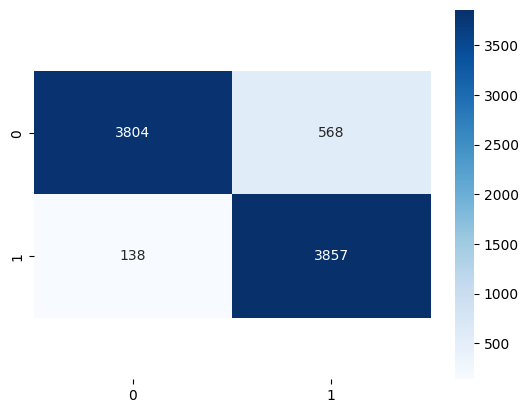

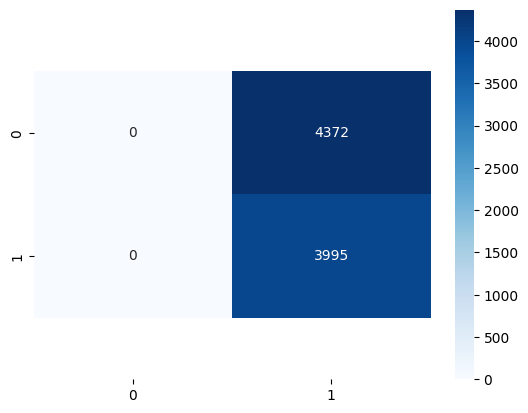

[[ True]
 [ True]
 [False]
 ...
 [ True]
 [False]
 [False]]


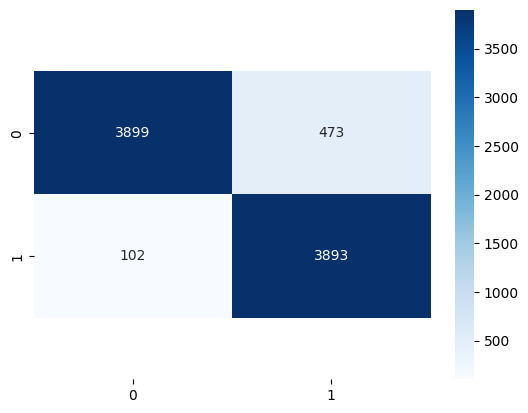

[[ True]
 [ True]
 [False]
 ...
 [ True]
 [False]
 [False]]


In [ ]:
#Model Evaluation
high_risk_real_value = -5.0
low_risk_real_value  = -6.1
classification_threshold = 0.25

def evaluate(y_pred):
    
    #getting numeric predictions from boolean predictions
    y_pred_numeric = np.zeros((y_pred.shape[0],y_pred.shape[1]))
    y_pred_numeric[y_pred==True] = low_risk_real_value
    y_pred_numeric[y_pred==False] = high_risk_real_value
    
    #getting predictions greater than -6.0 in real data (y_test_scaled)
    y_cv_scaled = y_scaler.inverse_transform(y_test_numeric)
    y_cv_mse = y_cv_scaled[np.where(y_cv_scaled >= -6.0)]
    y_pred_mse = y_pred_numeric[np.where(y_cv_scaled >= -6.0)]
    
    mse = mean_squared_error(y_cv_mse, y_pred_mse)
    
        
    hm = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt='d')# font size
    bottom, top = hm.get_ylim()
    hm.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

#Predicting with model
y_model = model.predict(X_test, batch_size=batch)
y_model = (y_model > classification_threshold).reshape(-1,1)
evaluate(y_model)

#Predicting -5 always
y_constant = np.ones((y_test.shape[0],y_test.shape[1]), dtype=bool)
evaluate(y_constant)

#Predicting last value
y_last = X_test[:,-1,1]
y_last = (y_last > threshold_scaled).reshape(-1,1)
print(y_last)
evaluate(y_last)
print(y_last)


In [ ]:
used_features = df.columns.difference(['event_id'])

# Print the list of features
print("Feature columns:")
for feature in used_features:
    print(feature)


Feature columns:
AP
F10
F3M
SSN
azimuth
c_actual_od_span
c_cd_area_over_mass
c_cn_r
c_cn_t
c_cndot_n
c_cndot_r
c_cndot_rdot
c_cndot_t
c_cndot_tdot
c_cr_area_over_mass
c_crdot_n
c_crdot_r
c_crdot_t
c_ct_r
c_ctdot_n
c_ctdot_r
c_ctdot_rdot
c_ctdot_t
c_h_apo
c_h_per
c_j2k_ecc
c_j2k_inc
c_j2k_sma
c_object_type_DEBRIS
c_object_type_PAYLOAD
c_object_type_ROCKET BODY
c_object_type_TBA
c_object_type_UNKNOWN
c_obs_available
c_obs_used
c_position_covariance_det
c_recommended_od_span
c_residuals_accepted
c_sedr
c_sigma_n
c_sigma_ndot
c_sigma_r
c_sigma_rdot
c_sigma_t
c_sigma_tdot
c_span
c_time_lastob_end
c_time_lastob_start
c_weighted_rms
elevation
event_length
geocentric_latitude
mahalanobis_distance
max_risk_estimate
max_risk_scaling
miss_distance
mission_id_1
mission_id_10
mission_id_13
mission_id_14
mission_id_15
mission_id_16
mission_id_18
mission_id_19
mission_id_2
mission_id_20
mission_id_22
mission_id_23
mission_id_24
mission_id_3
mission_id_4
mission_id_5
mission_id_6
mission_id_7
mission_

In [ ]:
y_last = X_test[:,-1,]
print(y_last.shape)
print(y_last)



(8367, 124)
[[0.40230747 0.35696701 0.36908525 ... 0.         0.         0.9047619 ]
 [0.53528781 0.85299407 0.54192482 ... 0.         1.         0.9047619 ]
 [0.42994119 0.         0.47064219 ... 0.         0.         0.95238095]
 ...
 [0.51427791 0.15357299 0.45196463 ... 0.         0.         0.9047619 ]
 [0.16742953 0.         0.34063605 ... 0.         0.         0.9047619 ]
 [0.48551691 0.         0.49868441 ... 0.         0.         0.85714286]]


In [52]:
tf.saved_model.save(model, 'risk_model')

INFO:tensorflow:Assets written to: risk_model\assets


INFO:tensorflow:Assets written to: risk_model\assets


In [54]:
joblib.dump(model, 'risk_model.joblib')

['risk_model.joblib']

In [56]:
model1 = joblib.load('risk_model.joblib')

262/262 [==============================] - 1s 3ms/step


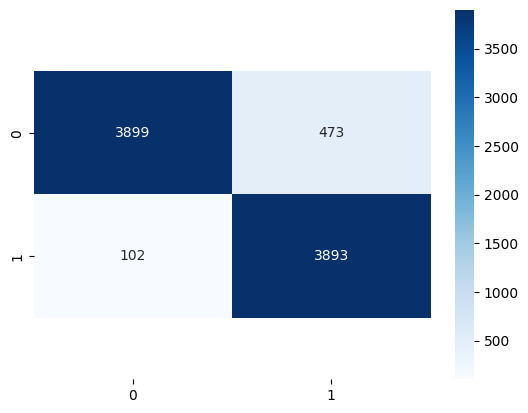

[[ True]
 [ True]
 [False]
 ...
 [ True]
 [False]
 [False]]
